In [1]:
import os
import glob

import numpy as np
import xarray as xr

import csv
import pop_tools

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean.cm as cmo

In [2]:
# Define parameters
raw_files = glob.glob(os.path.expanduser('~/phase1_CONDA/') + 'timeseries/*time_series.npy')
h = 7
window_size = 40
duration_threshold = 20
threshold_multiple = 3

# Load signal data for the first plot
signals = np.load(raw_files[7])
hist_end = (2014 - 1850) * 12
signals = signals[:hist_end]
time_annual = np.arange(1850, 1850 + (hist_end / 12))

# Read the order file
with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
    vvel_list = file.readlines()
vvel_dict = {int(line.split()[0]): line.split()[1] for line in vvel_list}

# Load data from 'events_dens_spg.csv' to get member numbers
data = np.genfromtxt('events_dens_spg.csv', delimiter=',', names=True, dtype=None)
member_numbers = data['Index']

# Process data for the first plot
last_member_name = vvel_dict[member_numbers[-3]][5:]
signal = signals[:, member_numbers[-3]][:hist_end]
annual_mean = np.mean(signal.reshape(-1, 12), axis=1)

# Identify events for the second plot
criteria_indices_dict = {}

for i, signal in enumerate(signals.T):
    annual_means = np.mean(signal.reshape(-1, 12), axis=1)
    criteria_indices = []
    for j in range(window_size, len(annual_means) - duration_threshold):
        window = annual_means[j - window_size:j]
        std_window = np.std(window)
        avg_window = np.mean(window)
        threshold = annual_means[j:j + duration_threshold]
        avg_threshold = np.mean(threshold)
        if avg_threshold >= avg_window + (threshold_multiple * std_window) or avg_threshold <= avg_window - (threshold_multiple * std_window):
            if len(criteria_indices) == 0 or j >= criteria_indices[-1] + duration_threshold:
                criteria_indices.append(j)
                #print(j)
    criteria_indices_dict[i] = criteria_indices

result = [(index, value) for index, value in criteria_indices_dict.items() if value]

with open('events_dens_spg.csv', 'w', newline='') as csvfile:
    fieldnames = ['Index', 'Values']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for index, values in result:
        writer.writerow({'Index': index, 'Values': values[0]})


# Annual Wind

In [3]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries/'
saved_data = []
for index, value in result:
    file_name = vvel_dict[index][5:-3] 
    #members_to_select.append(file_name)
    data = xr.open_dataarray(path+ 'monthly_tau_member_'+file_name+'.nc').values
    annual_means = np.mean(data.reshape(-1, 12), axis=1)
    start = values[0]
    end = values[0] + duration_threshold
    event = annual_means[start - window_size:end]
    saved_data.append((file_name, event))
    
sorted_data = sorted(saved_data, key=lambda x: x[0])

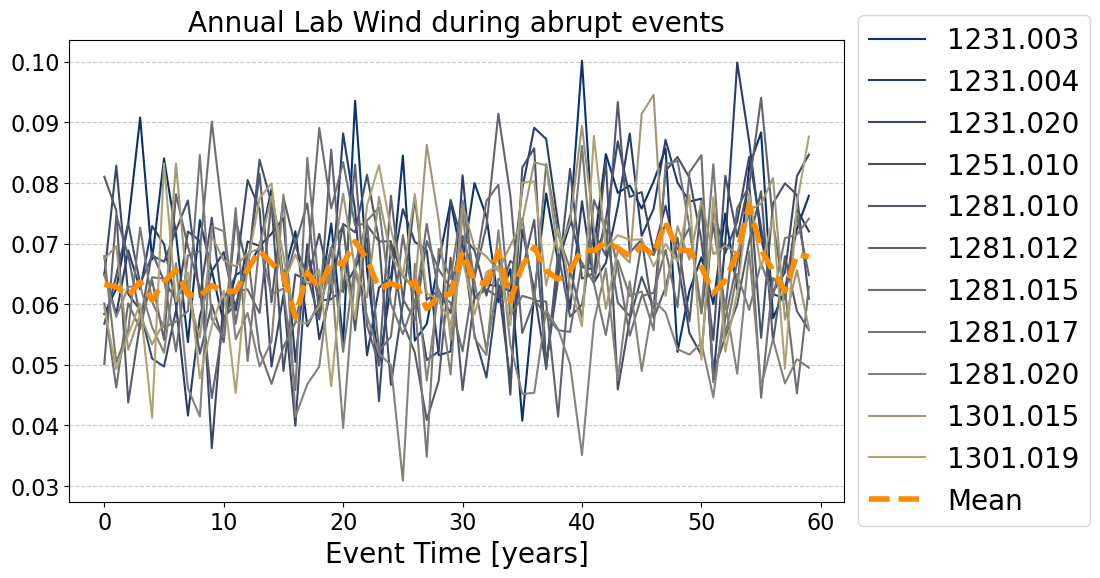

In [4]:
# Create colors array
colors = cm.cividis(np.linspace(0.1, 0.7, len(sorted_data[1:])))

# Initialize the list for time series data
time_series_list = []

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed

# Plot each time series with its corresponding color
for (file_name, timeseries), color in zip(sorted_data[1:], colors):
    if file_name != "1301.001":
        ax.plot(timeseries, label=file_name, color=color)
        time_series_list.append(timeseries)

# Compute the mean time series
mean_time_series = np.mean(time_series_list, axis=0)

# Plot the mean time series
ax.plot(mean_time_series, label='Mean', linestyle='--', color='darkorange', linewidth=4, zorder=110)

# Add legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)

# Set title and labels
ax.set_title(r'Annual Lab Wind during abrupt events', fontsize=20)
ax.set_xlabel('Event Time [years]', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add vertical and horizontal lines
#event_location = 40
#length = 60
#ax.axvline(x=event_location, color='r', linestyle='--', linewidth=2)
#ax.axhline(y=17, color=colors[0], label='Period 1', linewidth=10, 
#           xmin=(event_location - 40) / length, xmax=(event_location) / length)
#ax.axhline(y=17, color=colors[3], label='Period 2', linewidth=10, 
#           xmin=(event_location) / length, xmax=(event_location + 20) / length)

# Add text to indicate periods
#ax.text(17, 17.5, 'Period 1', weight='bold', color=colors[0], fontsize=20)
#ax.text(47, 17.5, 'Period 2', weight='bold', color=colors[3], fontsize=20)

# Show plot
#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Annual_Lab_Wind_Events.png', bbox_inches='tight', dpi=300)

# Annual Wind

In [5]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries/'
saved_data = []
for index, value in result:
    file_name = vvel_dict[index][5:-3] 
    #members_to_select.append(file_name)
    data = xr.open_dataarray(path+ 'monthly_shf_member_'+file_name+'.nc').values
    annual_means = np.mean(data.reshape(-1, 12), axis=1)
    start = values[0]
    end = values[0] + duration_threshold
    event = annual_means[start - window_size:end]
    saved_data.append((file_name, event))
    
sorted_data = sorted(saved_data, key=lambda x: x[0])

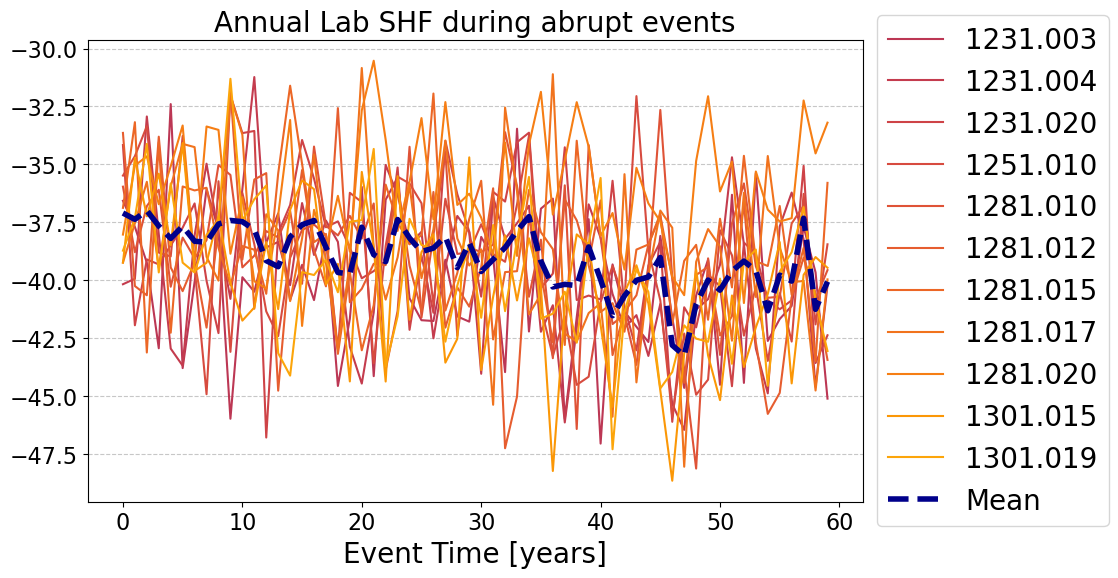

In [9]:
# Create colors array
colors = cm.inferno(np.linspace(0.5, 0.8, len(sorted_data[1:])))

# Initialize the list for time series data
time_series_list = []

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed

# Plot each time series with its corresponding color
for (file_name, timeseries), color in zip(sorted_data[1:], colors):
    if file_name != "1301.001":
        ax.plot(timeseries, label=file_name, color=color)
        time_series_list.append(timeseries)

# Compute the mean time series
mean_time_series = np.mean(time_series_list, axis=0)

# Plot the mean time series
ax.plot(mean_time_series, label='Mean', linestyle='--', color='darkblue', linewidth=4, zorder=110)

# Add legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)

# Set title and labels
ax.set_title(r'Annual Lab SHF during abrupt events', fontsize=20)
ax.set_xlabel('Event Time [years]', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add vertical and horizontal lines
#event_location = 40
#length = 60
#ax.axvline(x=event_location, color='r', linestyle='--', linewidth=2)
#ax.axhline(y=17, color=colors[0], label='Period 1', linewidth=10, 
#           xmin=(event_location - 40) / length, xmax=(event_location) / length)
#ax.axhline(y=17, color=colors[3], label='Period 2', linewidth=10, 
#           xmin=(event_location) / length, xmax=(event_location + 20) / length)

# Add text to indicate periods
#ax.text(17, 17.5, 'Period 1', weight='bold', color=colors[0], fontsize=20)
#ax.text(47, 17.5, 'Period 2', weight='bold', color=colors[3], fontsize=20)

# Show plot
#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Annual_Lab_SHF_Events.png', bbox_inches='tight', dpi=300)